In [1]:
import pandas as pd
import numpy as np
import gc
import pickle
from matplotlib import pyplot as plt
from datetime import datetime
import time

%matplotlib inline
import seaborn as sns

from sklearn import metrics

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
sns.set()

## !wget https://springernature.figshare.com/ndownloader/files/34135113

Given that the dataset contains recordings of vitals for 30 patients, to make the data easy to handle, we first created a list of dataframes where each dataframe contained per patient data

In [2]:
## a list to store the data for each patient 
dfs_list = []

We first start by loading the data...

In [3]:
f = open('./dataset_OSAS.pickle', 'rb')
data = pickle.load(f)
f.close()

Here we parse the entire data, remove duplicates and initialize the list of dataframes

In [4]:
## dropping duplicates from the data 
for i in range(1,31,1):
    df = data[data['patient'] == str(i)]
    df.drop_duplicates(subset=['timestamp_datetime'], inplace=True)
    dfs_list.append(df)

/tmp/ipykernel_298647/2526491877.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['timestamp_datetime'], inplace=True)


As a first step towards EDA, we first wanted to see different statistics associated with each feature for our better understanding of the nature of the data we are handling

In [5]:
data.describe()

,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min)
count,957813.000000,828777.000000,828102.000000,942901.000000,957813.000000
mean,64.683292,95.479754,3.981212,15.894219,0.629161
std,14.302865,2.875233,2.416226,3.689678,2.308404
min,30.000000,60.000000,0.060000,5.000000,0.000000
25%,54.000000,94.000000,2.200000,13.000000,0.000000
50%,62.000000,96.000000,3.510000,15.000000,0.000000
75%,74.000000,97.000000,5.270000,18.000000,0.000000
max,168.000000,100.000000,20.000000,36.000000,123.000000


We first plotted the number of events per patient i.e apnea and hypopnea to see how the distribution events across subjects

Text(0.5, 1.0, 'Number of Hypopnea Event for each Patient')

/home/hj/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


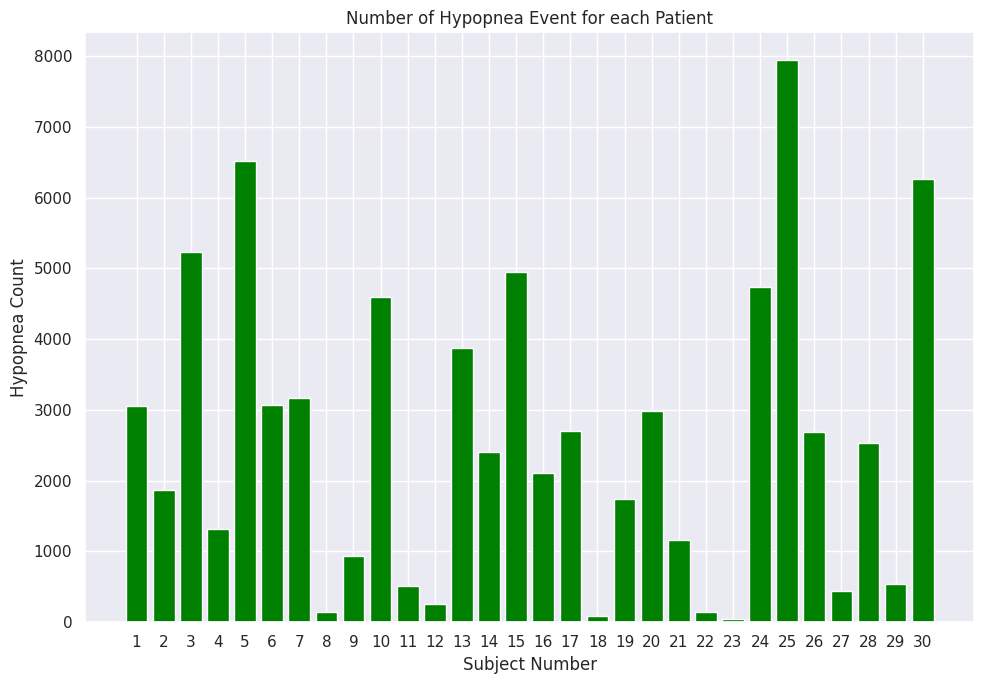

In [6]:
### plotting counts of hypoapnea events for each patient 
hypopnea_list = []

for i in range(1,31,1):
    temp = data[data['patient'] == str(i)]
    temp = temp['event'].value_counts()
    temp = pd.DataFrame(temp)
    temp.reset_index(inplace = True)
    hypoapnea = temp.loc[temp['index'] == 'HYPOPNEA']['event'].iloc[0]
    hypopnea_list.append(hypoapnea)

plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True
x_vals = range(1,31,1)
plt.bar(x_vals, hypopnea_list, color = 'green')
plt.xticks(x_vals)
plt.xlabel("Subject Number")
plt.ylabel("Hypopnea Count")
plt.title("Number of Hypopnea Event for each Patient")

30


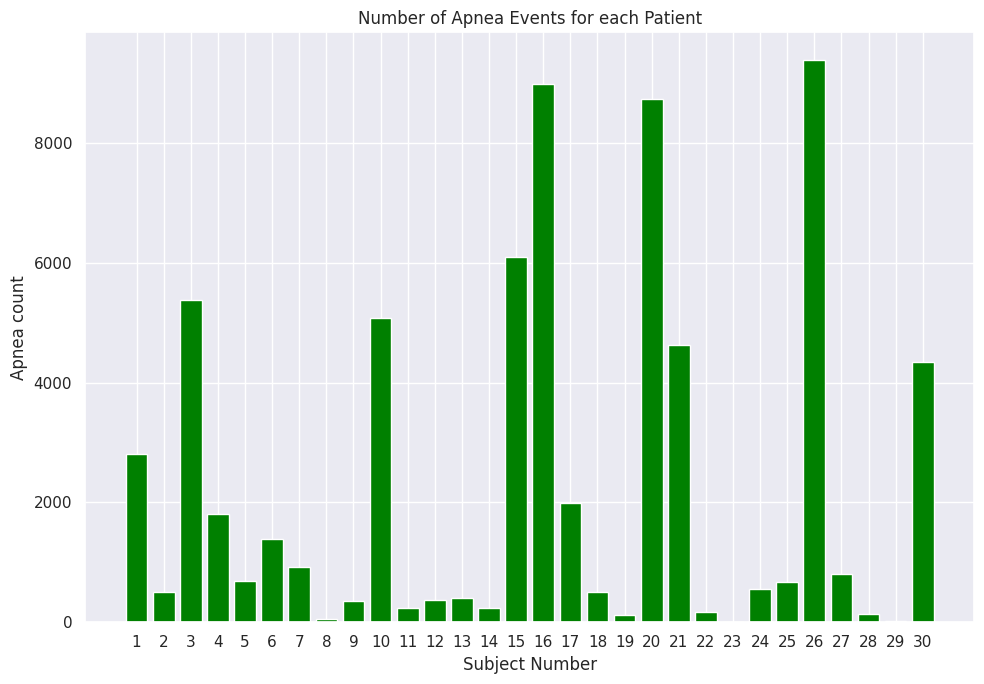

In [7]:
apnea_list = []
print(len(dfs_list))

for i in range(0,30,1):
    temp = dfs_list[i].query("event != 'HYPOPNEA'").query("event != 'NONE'")
    apnea_list.append(len(temp))

plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True
x_vals = range(1,31,1)
plt.bar(x_vals, apnea_list, color = 'green')
plt.xticks(x_vals)
plt.xlabel("Subject Number")
plt.ylabel("Apnea count")
plt.title("Number of Apnea Events for each Patient")

plt.show()

Since we had the recording of a number of vitals in the dataset, it seemed like a good idea to find the relationship between different features. First, we found out the covariance in the dataset between all the numeric values.However, ad can be seen from the table, we were not able to find a statiscially significant result

In [8]:
data.cov()

/tmp/ipykernel_298647/4020818503.py:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.cov()


,HR(bpm),SpO2(%),PI(%),RR(rpm),PVCs(/min),anomaly
HR(bpm),204.571948,-4.193349,-9.061032,17.302908,7.391100,-0.008272
SpO2(%),-4.193349,8.266963,-1.597757,-1.355408,-0.591348,-0.074999
PI(%),-9.061032,-1.597757,5.838146,-1.030264,-0.340358,-0.048826
RR(rpm),17.302908,-1.355408,-1.030264,13.613726,1.470620,0.009669
PVCs(/min),7.391100,-0.591348,-0.340358,1.470620,5.328729,0.063249
anomaly,-0.008272,-0.074999,-0.048826,0.009669,0.063249,0.128399


Next, we created a correlation matrix to see if any correlations exist

/home/hj/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


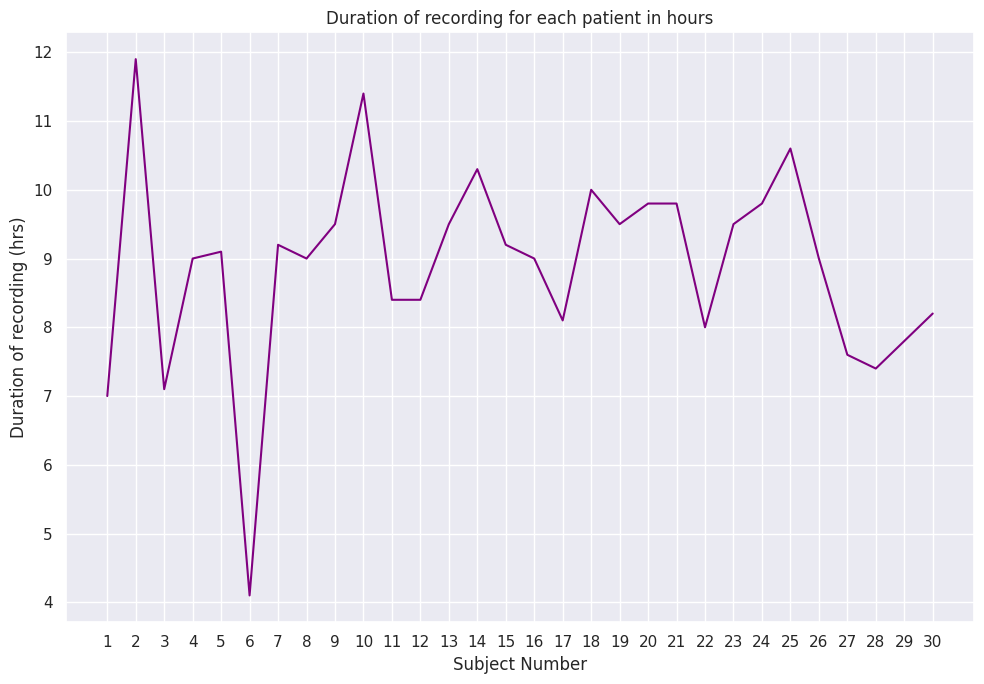

In [9]:
## finding the duration of time for each patient
count = 1
list_duration = []
for df in dfs_list:
    temp = list(df['timestamp_datetime'])
    t1 = temp[0]
    t2 = temp[-1]
    duration = round((t2 - t1).total_seconds() / 3600,1)
    list_duration.append(duration)

plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True
x_vals = range(1,31,1)
plt.plot(x_vals, list_duration, color = 'purple')
plt.xticks(x_vals)
plt.xlabel("Subject Number")
plt.ylabel("Duration of recording (hrs)")
plt.title("Duration of recording for each patient in hours")

plt.show()

As can be seen, there is a significant difference in the duration of recording between the subjects, especially for subject 6 and 12. Later as we analyse the data, we will explore further how that factors into the detection of apnea events.

Next we attempt to get an understanding of data ranges.

/home/hj/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


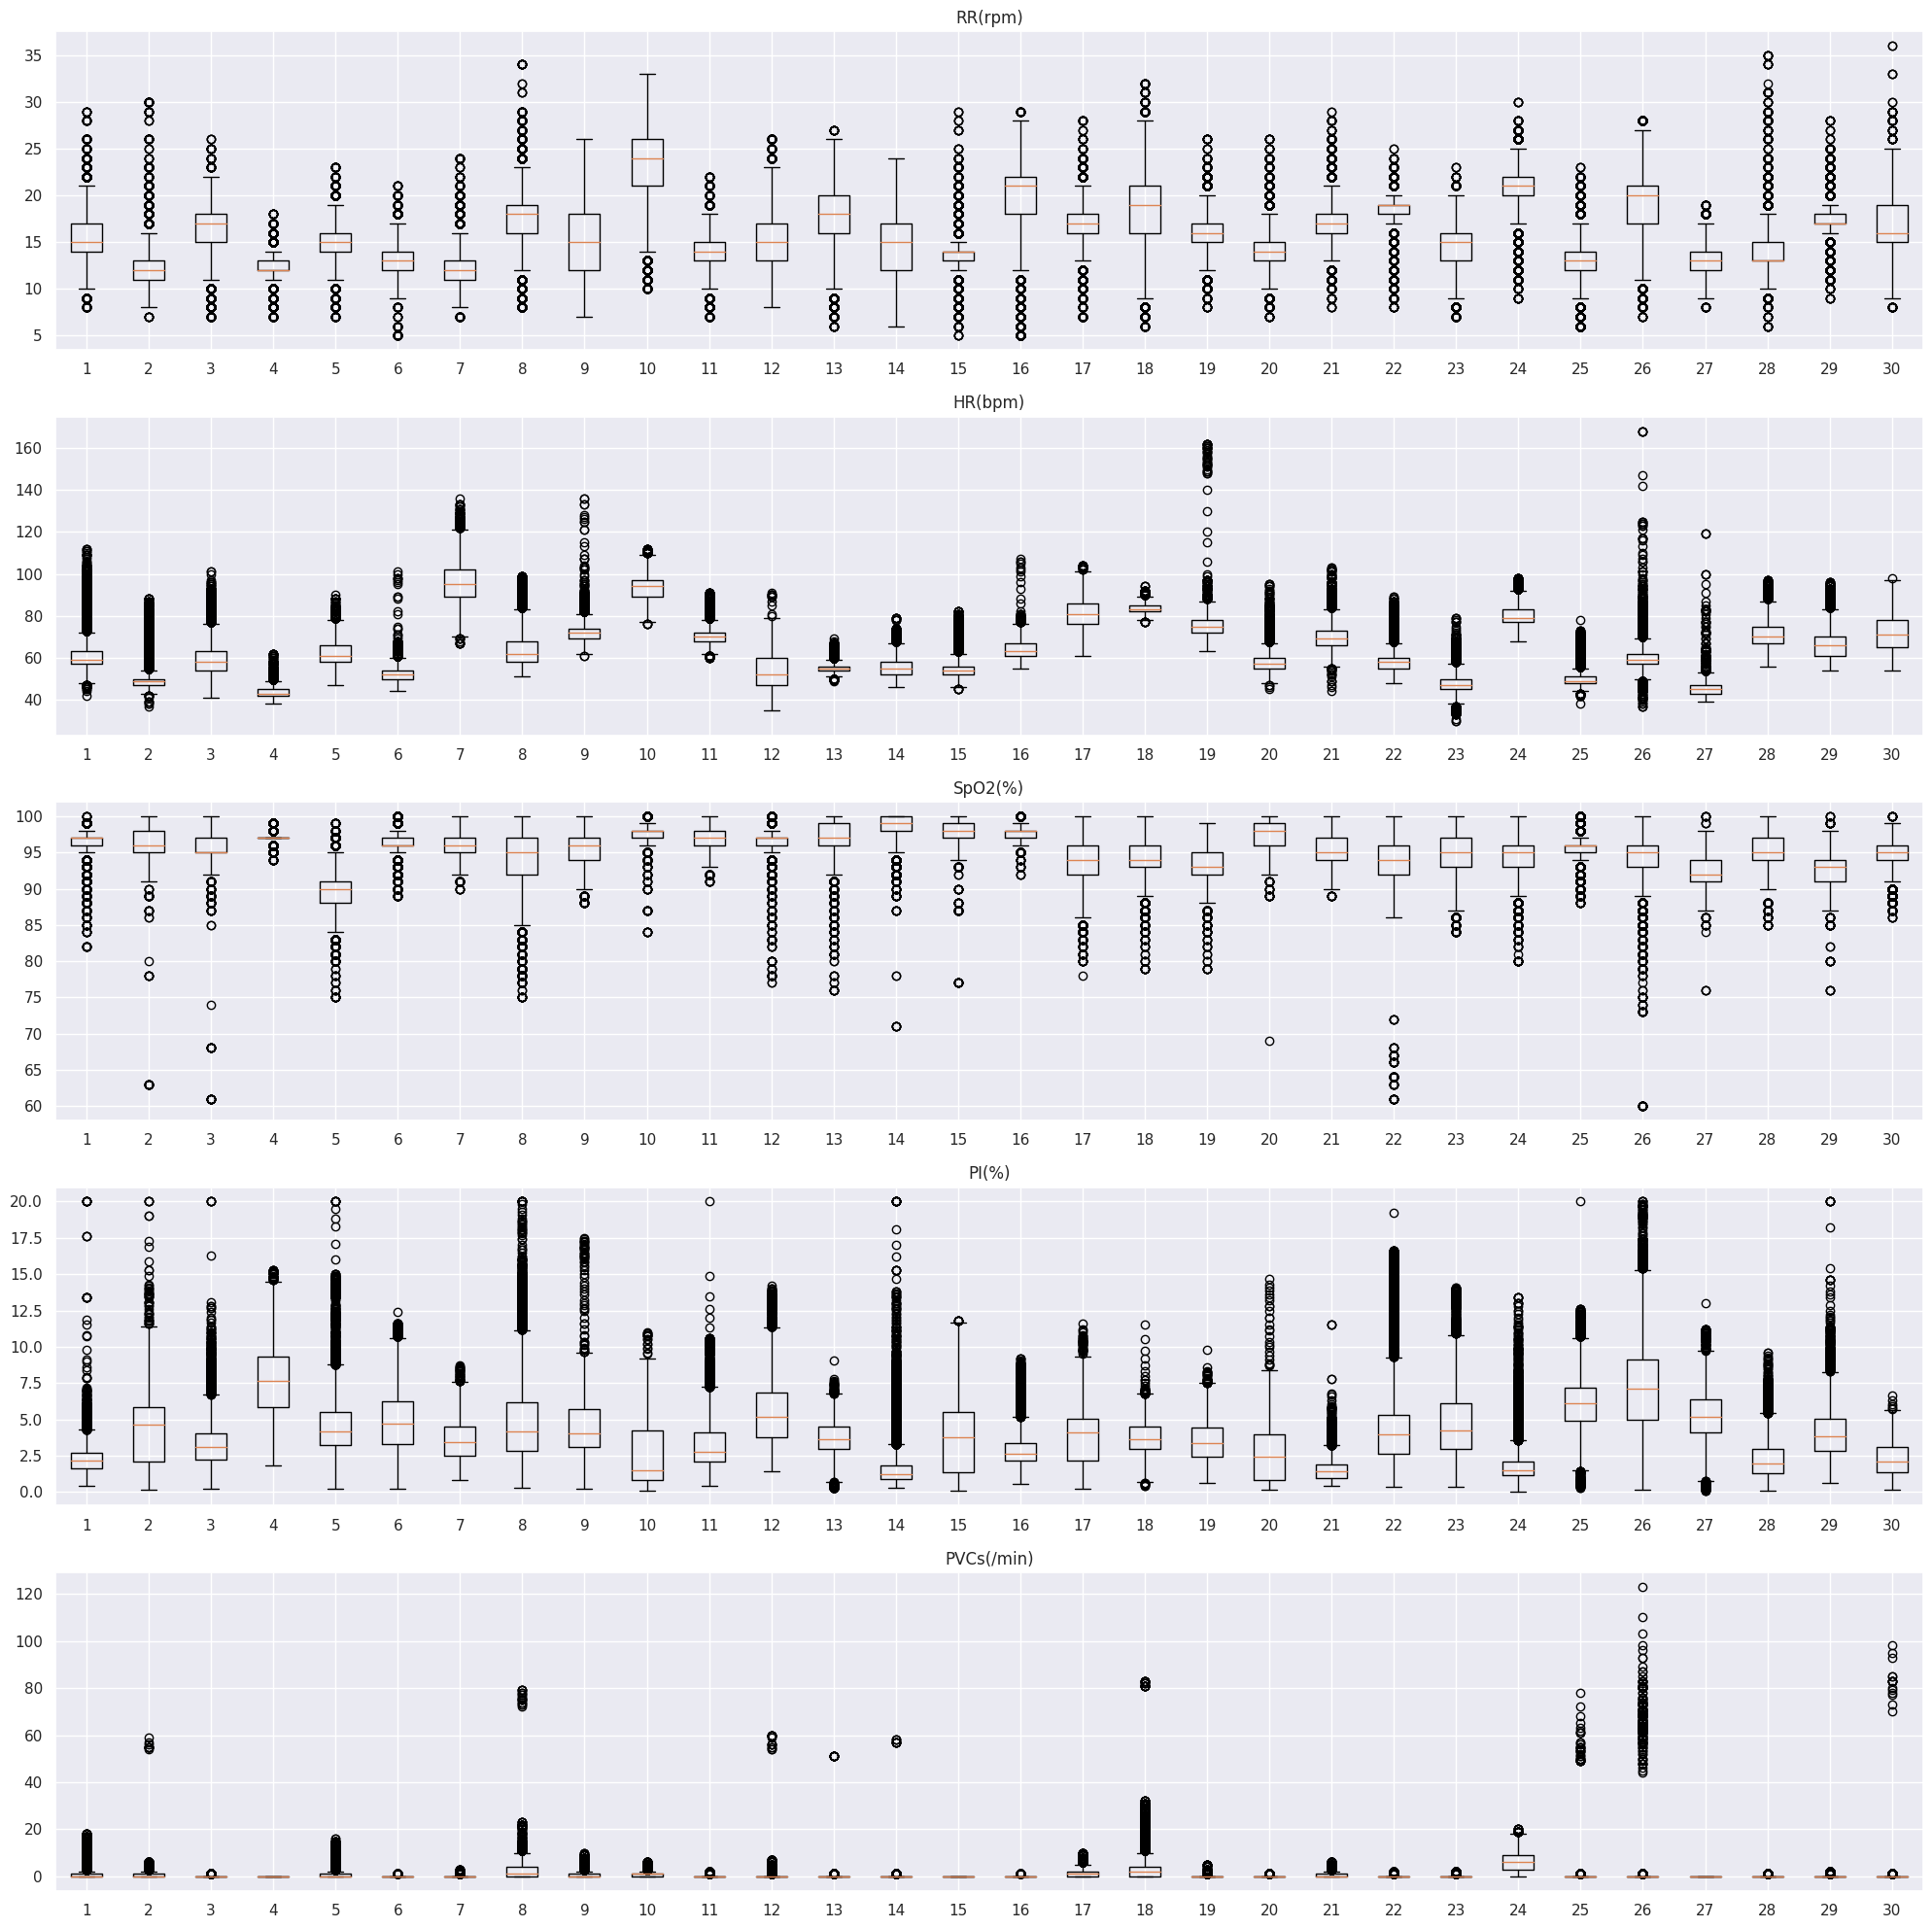

In [10]:
features = ['RR(rpm)', 'HR(bpm)', 'SpO2(%)', 'PI(%)', 'PVCs(/min)']

fig, ax = plt.subplots(nrows=len(features), ncols=1, figsize=(20,20))

## For each feature for the each patient, do a box plot
for index in range(len(features)):
    o = ax[index].set_title(features[index])
    
    patient_data = []
    for patient_id in np.unique(data['patient']):
        temp = data[data['patient'] == patient_id][features[index]]
        patient_data.append([x for x in list(temp.values) if not np.isnan(x)] )
    
    ax[index].boxplot(patient_data)

plt.show()

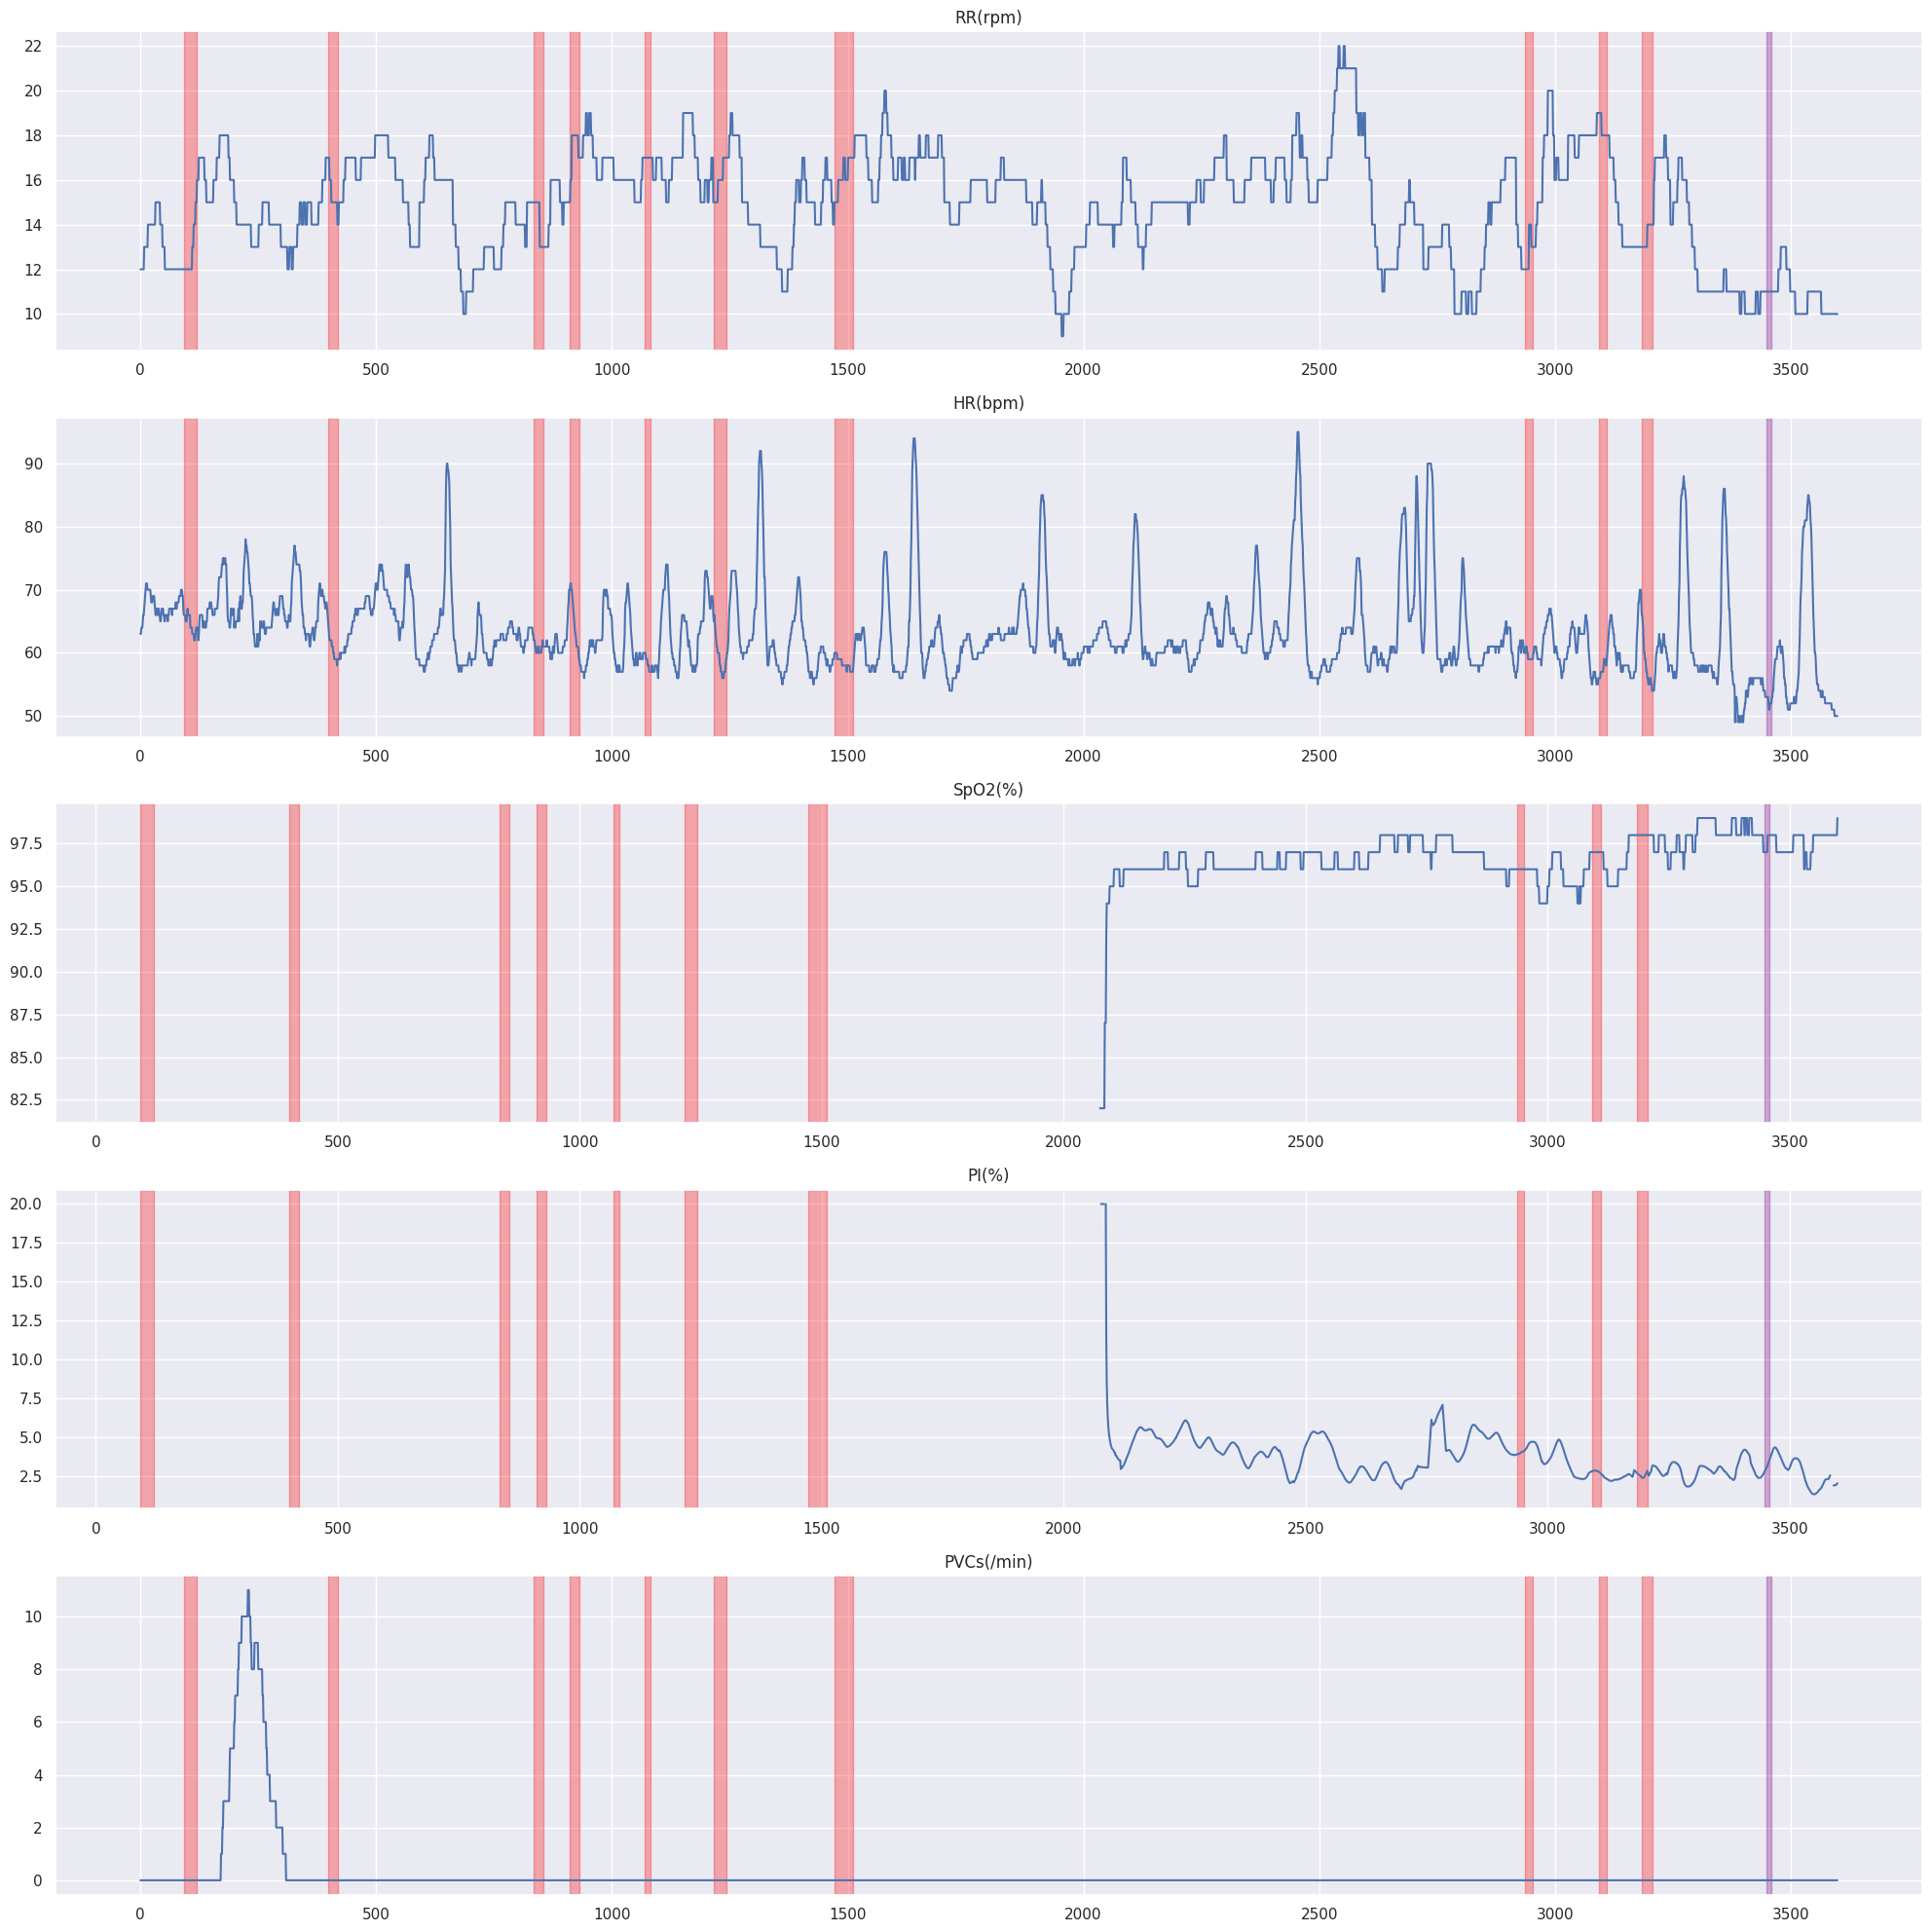

In [11]:
## Plot an hour of data for each of the features
## If you notice, the plots for SpO2 and PI% don't begin until around 2100 for patient 1
## The values for the first portions of the data are NaNs so the data is missing
## The fact that there is missing data can be seen more clearly in the bottom table where there is
##   approximately 8% data missing for both of these features.
## I believe that these two measurements are often collected via the same device so it is likely that
##   the NaNs are place values for the time prior to hooking up the device.
## In addition, the red markings on the time series plot indicates hypopnea events marked by a clinician
##   while the purple marking indicates an apnea event. Idealy we would be able to see some correlation.

## Takes a set of patient data (assumes only a single patient) and a start and end then returns
##    a list of start and ending tuples. You can also specify the types it expects a list of
##    the valid types such as ['APNEA-CENTRAL' 'APNEA-MIXED' 'APNEA-OBSTRUCTIVE' 'HYPOPNEA' 'NONE']
def get_list_of_events(df, start, end, event_type):
    
    ## Will be in the format of [ (start1, end1), (start2, end2)] ]
    event_list = []
    
    current_start = 0
    
    ## State identifier if we are inside of an event range or out of it
    in_event = 0
    
    for i in range(start, end + 1):
        ## We are in an event if it is both the correct type and we have encountered a 1
        if df['anomaly'][i] == 1 and in_event == 0 and df['event'][i] in event_type:
            in_event = 1
            current_start = i
        elif df['anomaly'][i] == 1 and in_event == 1 and df['event'][i] not in event_type:
            ## If we are in an event and the type switches we have to stop
            in_event = 0
            event_list.append( (current_start, i - 1) )
        elif df['anomaly'][i] == 0 and in_event == 1:
            in_event = 0
            event_list.append( (current_start, i - 1) )
    
    return event_list
        
fig, ax = plt.subplots(nrows=len(features), ncols=1, figsize=(20,20))

## For each feature for the first patient, graph a time series over the first hour of monitoring
for index in range(len(features)):
    ax[index].set_title(features[index])
    
    ## Only take the first hour of data
    plot_data = data[data['patient'] == '1'][features[index]].head(3600)
    
    ax[index].plot(list(range(0,3600)), plot_data, color='b')
    
    apnea_events = get_list_of_events(data[data['patient'] == '1'], 0, 3600, ['APNEA-CENTRAL','APNEA-MIXED','APNEA-OBSTRUCTIVE'])
    hypopnea_events = get_list_of_events(data[data['patient'] == '1'], 0, 3600, ['HYPOPNEA'])
    
    for start, end in apnea_events:
        ax[index].axvspan(start, end, color="purple", alpha=0.3)
        
    for start, end in hypopnea_events:
        ax[index].axvspan(start, end, color="red", alpha=0.3)
    
plt.show()

In [12]:
## Calculate missing data %

## Some of these patients have significant chunks of missing data primarily in regards to SpO2 and PI%
##  Given how much is missing we may not be able to depend too heavily on these features for training our model.

patient_missing = {}

for feat in features:

    patient_missing[feat] = []
    
    for patient_id in np.unique(data['patient']):
        temp = data[data['patient'] == patient_id][feat]
        vals = list(temp.values)
        missing = len([x for x in vals if np.isnan(x)] ) / len(vals)
        patient_missing[feat].append(missing)

df = pd.DataFrame(patient_missing, index = np.unique(data['patient']))
display(df)

,RR(rpm),HR(bpm),SpO2(%),PI(%),PVCs(/min)
1,0.000040,0.000040,0.083287,0.084598,0.000040
10,0.058771,0.058454,0.177870,0.178991,0.058454
11,0.000033,0.000033,0.220888,0.222500,0.000033
12,0.015027,0.000033,0.000066,0.000066,0.000033
13,0.001645,0.000059,0.019127,0.020302,0.000059
14,0.001219,0.000027,0.025975,0.026842,0.000027
15,0.006132,0.001933,0.190545,0.190606,0.001933
16,0.044314,0.000464,0.119314,0.120674,0.000464
17,0.002415,0.000034,0.657295,0.657640,0.000034
18,0.000028,0.000028,0.373101,0.373686,0.000028


In [13]:
# Chose three random patients to show 
pt_nums = ['9', '17', '21']
events = ['PSG_Flow', 'PSG_Abdomen', 'PSG_Position', 'PSG_Snore', 'PSG_Thorax']

[False False False ... False False False]
0 4000


IndexError: invalid index to scalar variable.

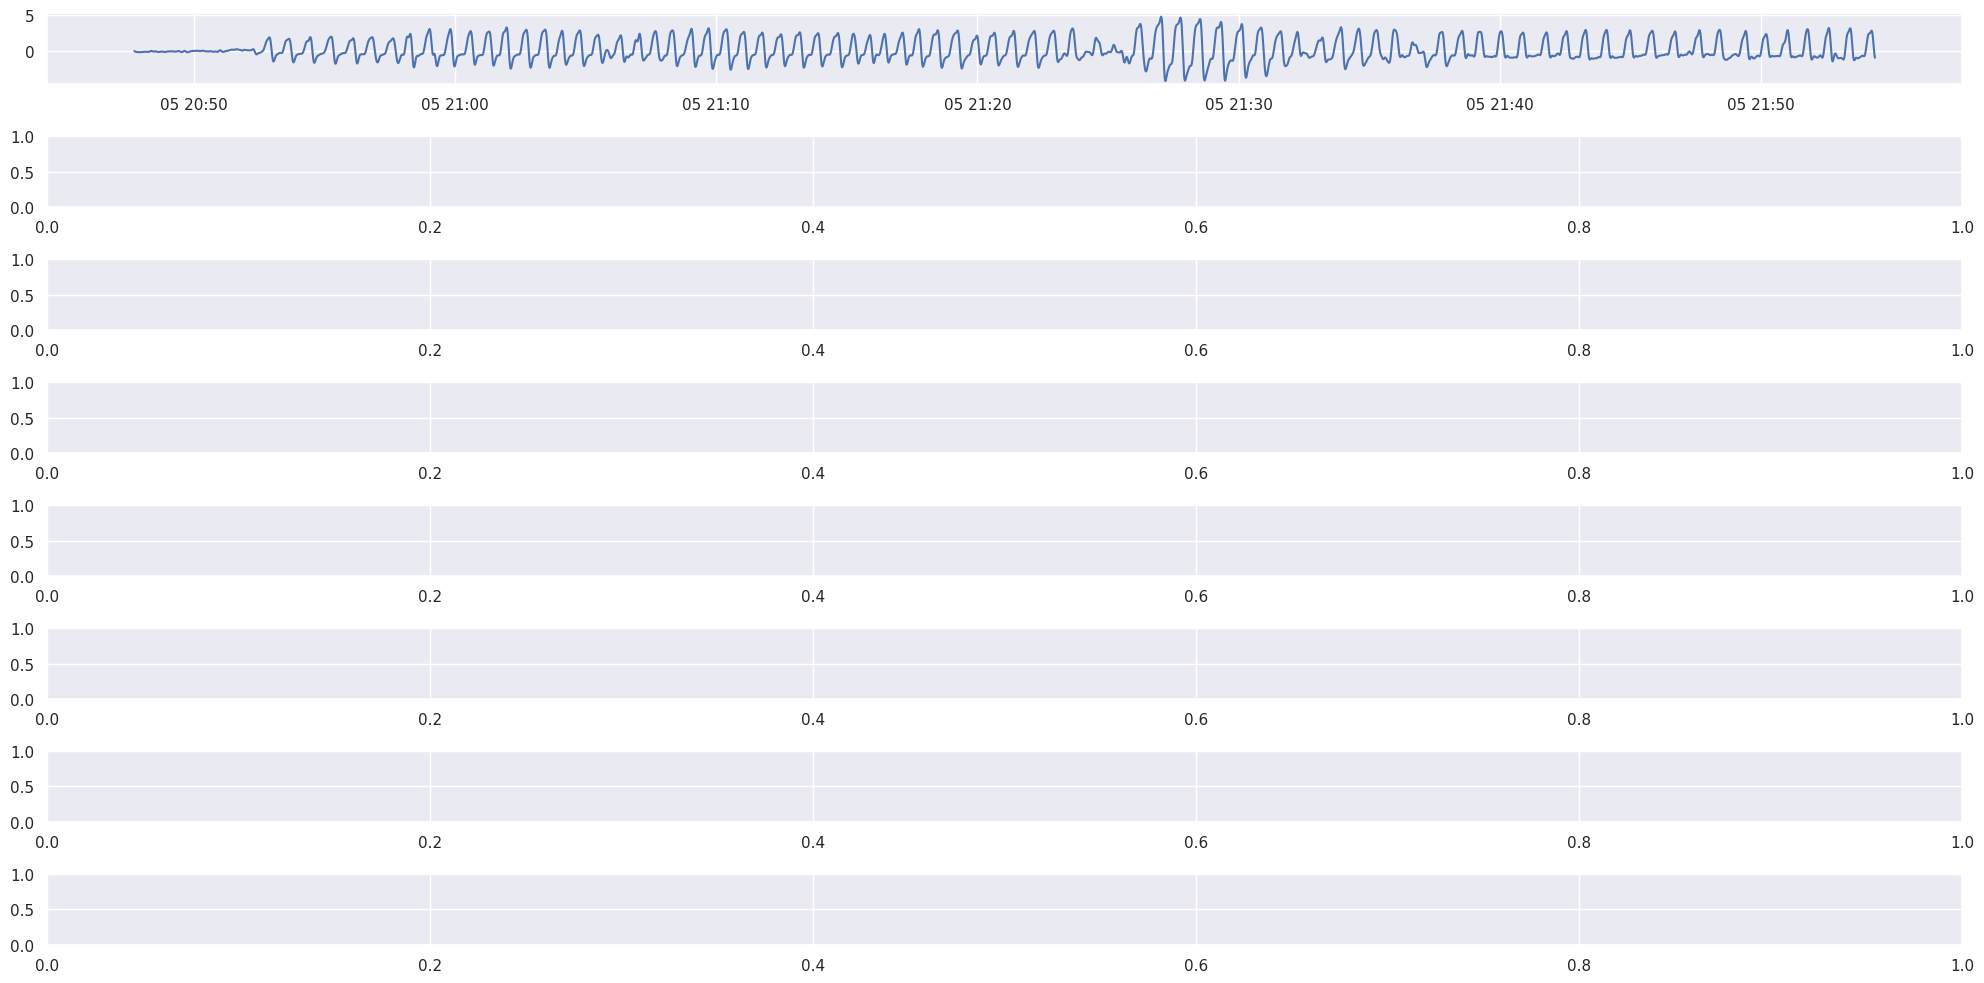

In [18]:
for pt_num in pt_nums:
    patient = data[data['patient'] == pt_num]
    time = patient['timestamp_datetime']
    event = patient['event']
    
    for e in events:

        psg = patient[e]

        # collecting the data in an easier form to plot
        huge_arr = []
        time_arr = []
        event_arr = []
        for i in event.index:
            event_arr = np.append(event_arr, event[i])
            huge_arr = np.append(huge_arr, psg[i])
            time_arr = np.append(time_arr, time[i])

        # setting up plots -- 4000 was a number of points I chose that I thought 
        # didn't look too crowded in the space allocated for the plot
        num_plots = int(len(time_arr)/4000)
        fig, axs = plt.subplots(num_plots)
        fig.set_figheight(10)
        fig.set_figwidth(20)
        fig.tight_layout()
        start = 0
        end = 4000
        for i in range(num_plots):
            # find the hypopnea and apnea events
            hypopnea = (event_arr[start:end] == 'HYPOPNEA')
            apnea = (event_arr[start:end] == 'APNEA-OBSTRUCTIVE')
            # plot the time series
            axs[i].plot(time_arr[start:end], huge_arr[start:end])
            # plot the hypopnea and apnea events
            for j in range(len(hypopnea)):
                print(j, len(hypopnea))
                if hypoapnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='red', alpha=0.1)
            for j in range(len(apnea)):
                if apnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='purple', alpha=0.1)
            start += 4000
            end += 4000

        axs[0].set_title(str(e) + " for Patient "+ str(pt_num)+", Red = Hypopnea, Purple = Apnea")
        axs[num_plots-1].set_xlabel("Time")

In [15]:
ecg_events = ['signal_ecg_i', 'signal_ecg_ii', 'signal_ecg_iii']

TypeError: object of type 'numpy.int64' has no len()

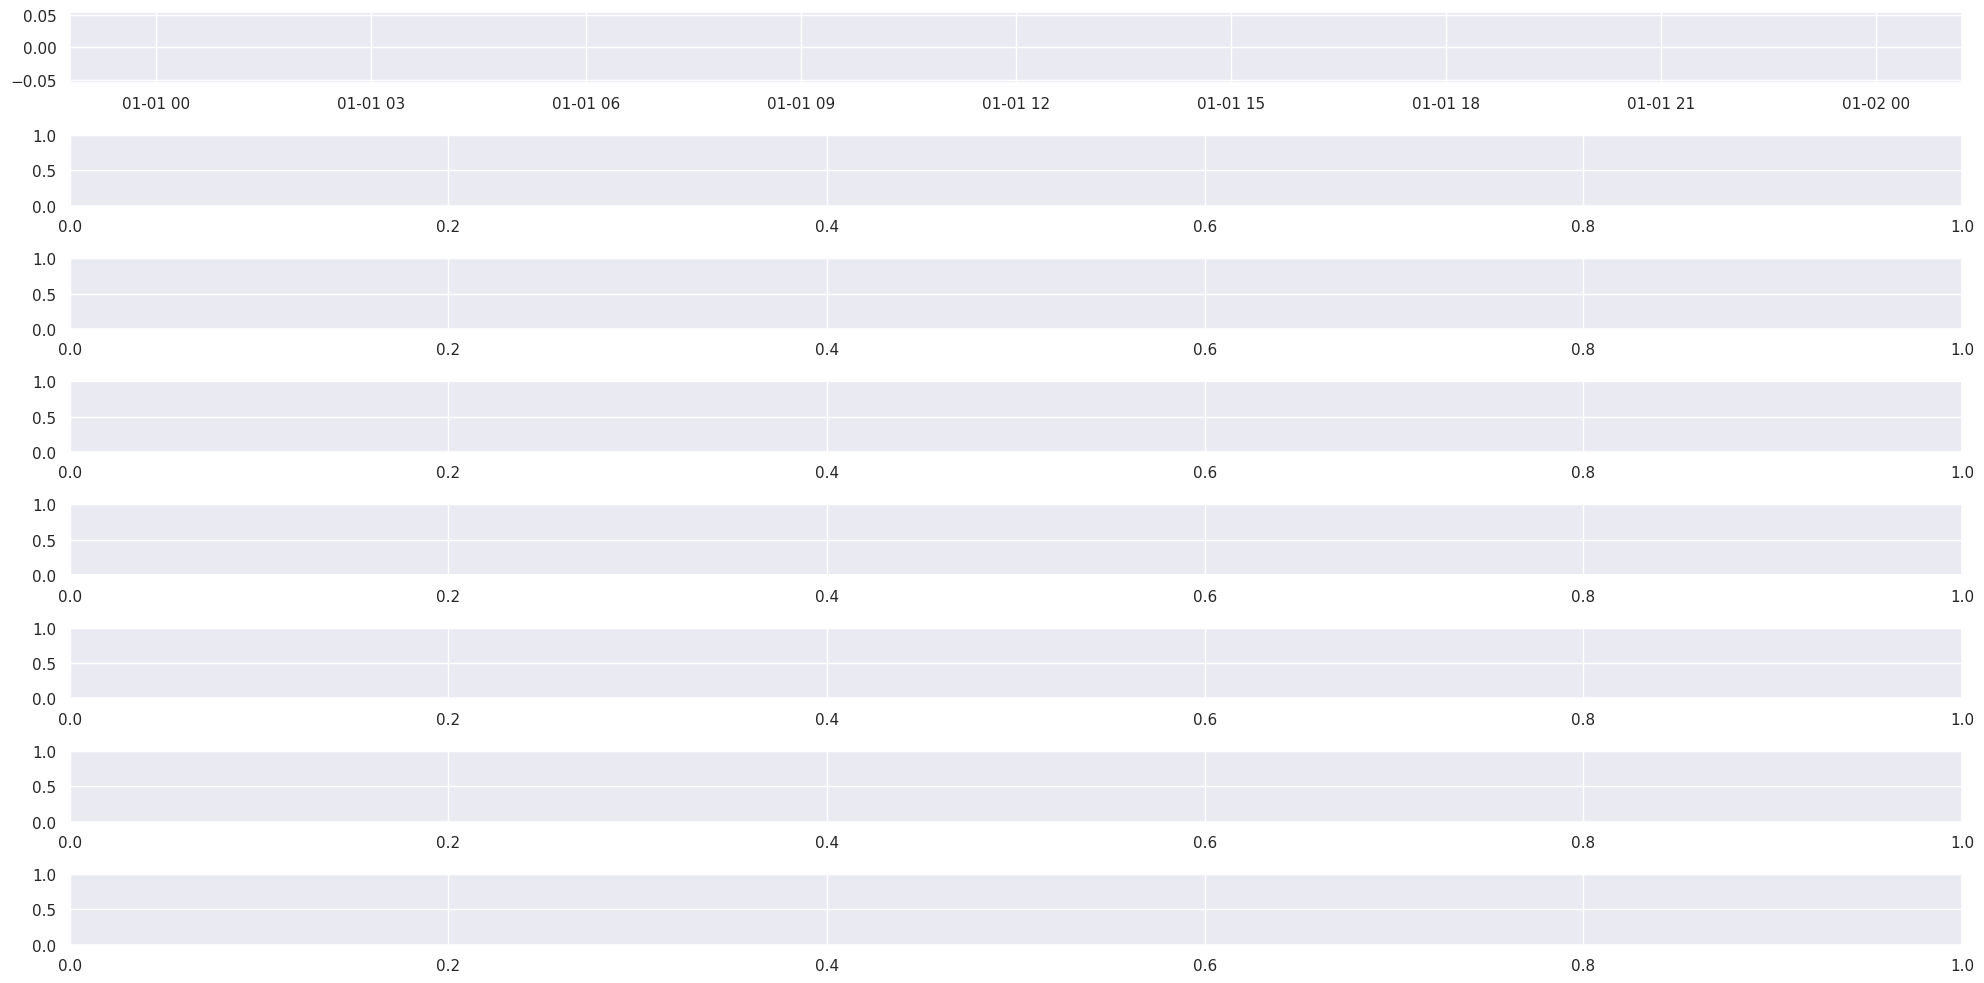

In [16]:
#signal_ecg_i

for pt_num in pt_nums:
    patient = data[data['patient'] == pt_num]
    time = patient['timestamp_datetime']
    event = patient['event']
    
    # collecting the data in an easier form to plot
    for e in ecg_events:

        ecg = patient[e]

        huge_arr = []
        time_arr = []
        event_arr = []
        for i in event.index:
            event_arr = np.append(event_arr, event[i])
            huge_arr = np.append(huge_arr, ecg[i])
            time_arr = np.append(time_arr, time[i])

        # setting up plots -- 4000 was a number of points I chose that I thought 
        # didn't look too crowded in the space allocated for the plot
        num_plots = int(len(time_arr)/4000)
        fig, axs = plt.subplots(num_plots)
        fig.set_figheight(10)
        fig.set_figwidth(20)
        fig.tight_layout()
        start = 0
        end = 4000
        for i in range(num_plots):
            # find the hypopnea and apnea events
            hypopnea = (event_arr[start:end] == 'HYPOPNEA')
            apnea = (event_arr[start:end] == 'APNEA-OBSTRUCTIVE')
            # plot the time series
            axs[i].plot(time_arr[start:end], huge_arr[start:end])
            # plot the hypopnea and apnea events
            for j in range(len(hypoapnea)):
                if hypoapnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='red', alpha=0.1)
            for j in range(len(apnea)):
                if apnea[j] == True:
                    axs[i].axvline(time_arr[start:end][j], color='purple', alpha=0.1)
            start += 4000
            end += 4000

        axs[0].set_title(str(e) + " for Patient "+ str(pt_num)+", Red = Hypopnea, Purple = Apnea")
        axs[num_plots-1].set_xlabel("Time")

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.violinplot(np.log(data['RR(rpm)']))

In [ ]:
sns.violinplot(np.log(data['HR(bpm)']))

In [ ]:
sns.violinplot(np.log(data['SpO2(%)']))

In [ ]:
sns.distplot(data['HR(bpm)'])

In [ ]:
sns.distplot(data['SpO2(%)'])

In [ ]:
num_cols=dataset.columns
dataset.corr() 

In [ ]:
dataset.corr('spearman')

In [ ]:
df = pd.DataFrame(dataset, columns=['RR(rpm)', 'HR(bpm)', 'SpO2(%)', 'PI(%)', 'PVCs(/min)'])

df.plot.area(stacked=False);

In [ ]:
from pandas.plotting import scatter_matrix

df = pd.DataFrame(dataset, columns=['RR(rpm)', 'HR(bpm)', 'SpO2(%)', 'PI(%)'])

scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal="kde");